# 1. Разведочный анализ данных.

На это этапе необходимо выполнить следующие задачи:

- загрузить датасет `PolyAI/banking77` с Hugging Face;
- провести разведочный анализ данных;
- провести анализ баланса классов;
- разделение датасета на `train`, `val` и `test` выборки.

## 1.1 Загрузка датасета

Загрузим датасет используя библиотеку `datasets`.

In [90]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path

SEED = 42

In [12]:
dataset = load_dataset("PolyAI/banking77", revision="refs/convert/parquet",)

0000.parquet:   0%|          | 0.00/298k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/93.9k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [40]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10003
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3080
    })
})

In [33]:
df = pd.DataFrame(pd.concat((pd.DataFrame(dataset['train']), pd.DataFrame(dataset['test'])), ignore_index=True))
df

,text,label
0,I am still waiting on my card?,11
1,What can I do if my card still hasn't arrived ...,11
2,I have been waiting over a week. Is the card s...,11
3,Can I track my card while it is in the process...,11
4,"How do I know if I will get my card, or if it ...",11
...,...,...
13078,"If i'm not in the UK, can I still get a card?",24
13079,How many countries do you support?,24
13080,What countries do you do business in?,24
13081,What are the countries you operate in.,24


## 1.2 EDA и анализ распределения целевого признака

Видим, что датасет уже разбит на обучающую и тестовую выборку. Для удобвства создали единый DataFrame. Проверим наличие пропусков и дубликатов в датасете.

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13083 entries, 0 to 13082
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    13083 non-null  object
 1   label   13083 non-null  int64 
 2   intent  13083 non-null  object
dtypes: int64(1), object(2)
memory usage: 306.8+ KB


In [44]:
df.isna().sum()

text     0
label    0
dtype: int64

In [45]:
df.duplicated().sum()

np.int64(0)

Вывод: датасет не содержит пропусков и дубликатов

Сделаем еще один столбец в датасете, который будет хранить название класса, а не просто метку класса.

In [51]:
labels_name = dataset['train'].features['label'].names
labels_name

['activate_my_card',
 'age_limit',
 'apple_pay_or_google_pay',
 'atm_support',
 'automatic_top_up',
 'balance_not_updated_after_bank_transfer',
 'balance_not_updated_after_cheque_or_cash_deposit',
 'beneficiary_not_allowed',
 'cancel_transfer',
 'card_about_to_expire',
 'card_acceptance',
 'card_arrival',
 'card_delivery_estimate',
 'card_linking',
 'card_not_working',
 'card_payment_fee_charged',
 'card_payment_not_recognised',
 'card_payment_wrong_exchange_rate',
 'card_swallowed',
 'cash_withdrawal_charge',
 'cash_withdrawal_not_recognised',
 'change_pin',
 'compromised_card',
 'contactless_not_working',
 'country_support',
 'declined_card_payment',
 'declined_cash_withdrawal',
 'declined_transfer',
 'direct_debit_payment_not_recognised',
 'disposable_card_limits',
 'edit_personal_details',
 'exchange_charge',
 'exchange_rate',
 'exchange_via_app',
 'extra_charge_on_statement',
 'failed_transfer',
 'fiat_currency_support',
 'get_disposable_virtual_card',
 'get_physical_card',
 'gett

In [54]:
df['intent'] = df['label'].apply(lambda x: labels_name[x])

In [55]:
df

,text,label,intent
0,I am still waiting on my card?,11,card_arrival
1,What can I do if my card still hasn't arrived ...,11,card_arrival
2,I have been waiting over a week. Is the card s...,11,card_arrival
3,Can I track my card while it is in the process...,11,card_arrival
4,"How do I know if I will get my card, or if it ...",11,card_arrival
...,...,...,...
13078,"If i'm not in the UK, can I still get a card?",24,country_support
13079,How many countries do you support?,24,country_support
13080,What countries do you do business in?,24,country_support
13081,What are the countries you operate in.,24,country_support


Проанализиурем распределение классов в датасете с помощью методов **pandas**, а также визуализируем результат с помощью библиотеки **matplotlib.pyplot**

In [57]:
class_distribution = df['label'].value_counts()
class_distribution.describe()

count     77.000000
mean     169.909091
std       32.942207
min       75.000000
25%      152.000000
50%      167.000000
75%      199.000000
max      227.000000
Name: count, dtype: float64

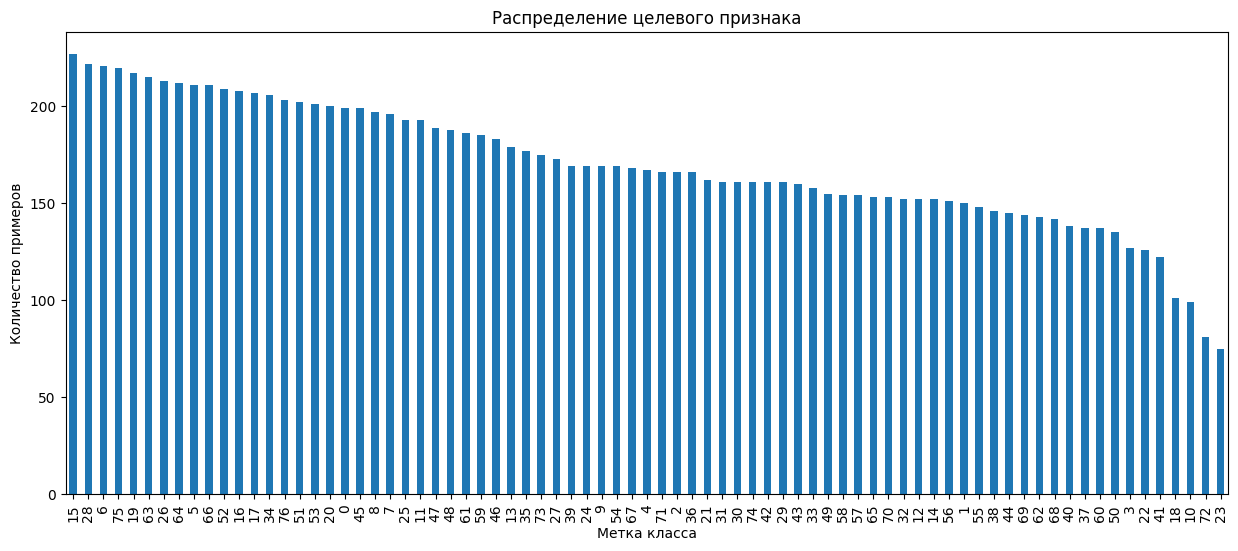

In [62]:
plt.figure(figsize=(15,6))
class_distribution.plot(kind='bar')
plt.title('Распределение целевого признака')
plt.xlabel('Метка класса')
plt.ylabel('Количество примеров')
plt.show()

Видим, что большинство классов имеет по 140 - 200 примеров, за исключением классов `18`, `10`, `72`, `23`.

**Вывод**: датасет имеет умеренный дисбаланс, который не является критическим. Балансировка данных не будем применять на этапе EDA, однако влияние дисбаланса будет учитываться на этапе обучения.

Следующий шаг - проверить длины текстовых документов.

In [68]:
df['text_length'] = df['text'].apply(lambda x: len(x.split()))
df['text_length'].describe()

count    13083.000000
mean        11.714744
std          7.636859
min          2.000000
25%          7.000000
50%         10.000000
75%         13.000000
max         79.000000
Name: text_length, dtype: float64

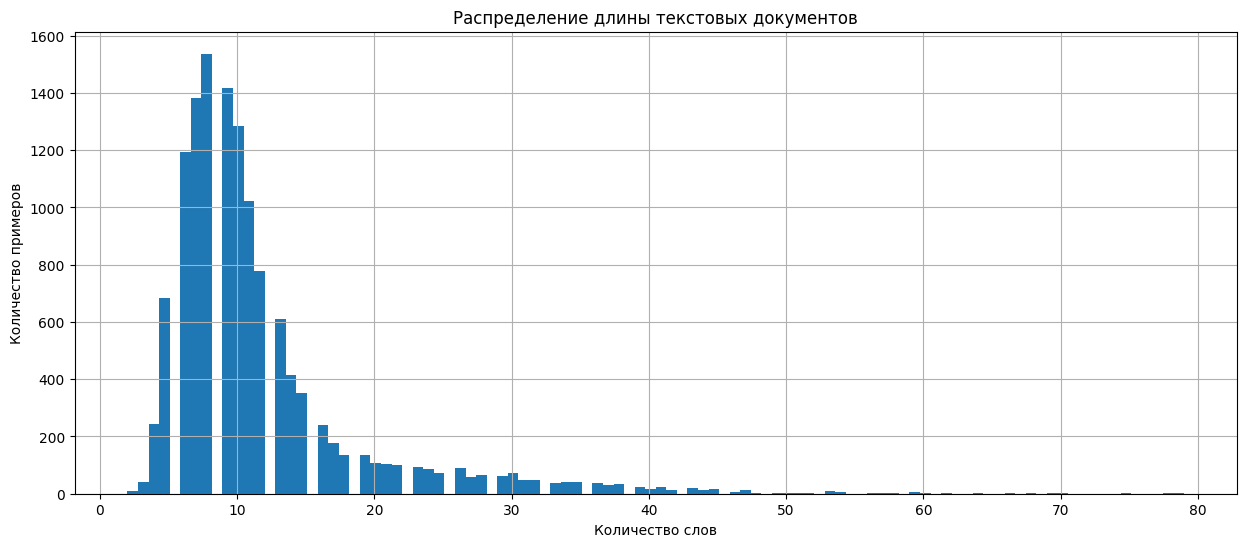

In [75]:
plt.figure(figsize=(15,6))
df['text_length'].hist(bins=100)
plt.title("Распределение длины текстовых документов")
plt.xlabel("Количество слов")
plt.ylabel("Количество примеров")
plt.show()

Можем заметить, что большинство тектовых документов имеет длину от 5 до 20 слов. Однако есть и тексты с 50 и даже с 80 словами. В дальнейших этапах стоит это учитывать, так как необходимо будет заполнять паддингами короткие последовательности или обрезать длинные.

## 1.3 Разделение датасета на train, val и test выборки

In [81]:
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])

Для начала разделим исходную тренировочную выборку на `train` и `val` в соотношении 80% (8000 документов) на 20% (2000 документов), что является стандартом машинного обучения и являестя достаточным для того, что модель обучилась на большем количестве примеров, и при мы смогли точно оценить ее качество с помощью валидационной выборки. Размеры выборок позволяют нам это сделать.

In [84]:
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=SEED, stratify=train_df['label'])
print(train_df.shape, val_df.shape, test_df.shape)

(8002, 2) (2001, 2) (3080, 2)


Проверим распределение целевого признака после разбиения датасета на выборки.

In [87]:
def check_distribution(df, name):
    print(f"\n{name}")
    print(df["label"].value_counts(normalize=True).describe())

check_distribution(train_df, "Train")
check_distribution(val_df, "Validation")
check_distribution(test_df, "Test")


Train
count    77.000000
mean      0.012987
std       0.003285
min       0.003499
25%       0.011247
50%       0.012747
75%       0.015871
max       0.018620
Name: proportion, dtype: float64

Validation
count    77.000000
mean      0.012987
std       0.003330
min       0.003498
25%       0.010995
50%       0.012494
75%       0.015992
max       0.018991
Name: proportion, dtype: float64

Test
count    7.700000e+01
mean     1.298701e-02
std      1.746099e-18
min      1.298701e-02
25%      1.298701e-02
50%      1.298701e-02
75%      1.298701e-02
max      1.298701e-02
Name: proportion, dtype: float64


Видим, что выборки распределены почти одинаково

Добавим также столбцы с названием целевых меток, как мы делали выше.

In [88]:
for dataframe in [train_df, val_df, test_df]:
    dataframe['intent'] = dataframe['label'].apply(lambda x: labels_name[x])

Сохраним наши выборки

In [95]:
DATA_DIR = Path("../data/processed")
DATA_DIR.mkdir(parents=True, exist_ok=True)

train_df.to_csv(DATA_DIR / "train_df.csv", index=False)
val_df.to_csv(DATA_DIR / "val_df.csv", index=False)
test_df.to_csv(DATA_DIR / "test_df.csv", index=False)

# Результаты этапа №1

В ходе разработке проекта на данном этапе было сделано следующее:

- Загрузили датасет через библиотеку `datasets`.
- Провели разведочный анализ данных и анализ распределения целевого признака. Поняли, что исходные уже чисты и имеют поправимый дисбаланс целевого признака;
- Разделили датасет на обучающую, валидационную и тестовую выборки.
- Сохранили выборки в формате *.csv*